In [1]:
%reset
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import collections 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import vonMises.vonMises as VM

from mdl_eval_tools import kl, logloss
from pprint import pprint
from scipy.stats import sem
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KernelDensity
from tqdm import tqdm

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
datapath_single = 'JNP_sim_neuron_data/'

datafolders = os.listdir(path=datapath_single)
datafolders = [f for f in datafolders if not f.startswith('.')]
# datafolders = [f for f in datafolders if f.endswith('.csv')]
print(len(datafolders))

print(datafolders)

50
['sim0', 'sim1', 'sim2', 'sim3', 'sim4', 'sim5', 'sim6', 'sim7', 'sim8', 'sim9', 'sim10', 'sim11', 'sim12', 'sim13', 'sim14', 'sim15', 'sim16', 'sim17', 'sim18', 'sim19', 'sim20', 'sim21', 'sim22', 'sim23', 'sim24', 'sim25', 'sim26', 'sim27', 'sim28', 'sim29', 'sim30', 'sim31', 'sim32', 'sim33', 'sim34', 'sim35', 'sim36', 'sim37', 'sim38', 'sim39', 'sim40', 'sim41', 'sim42', 'sim43', 'sim44', 'sim45', 'sim46', 'sim47', 'sim48', 'sim49']


In [3]:
modelpath = 'JNP_sim_model_fits/logoddsCompleteSinglePredMdls797/'

modelfolders = os.listdir(path=modelpath)
modelfolders = [f for f in modelfolders if not f.startswith('.')]
print(len(modelfolders))

print(modelfolders)

50
['sim0', 'sim1', 'sim2', 'sim3', 'sim4', 'sim5', 'sim6', 'sim7', 'sim8', 'sim9', 'sim10', 'sim11', 'sim12', 'sim13', 'sim14', 'sim15', 'sim16', 'sim17', 'sim18', 'sim19', 'sim20', 'sim21', 'sim22', 'sim23', 'sim24', 'sim25', 'sim26', 'sim27', 'sim28', 'sim29', 'sim30', 'sim31', 'sim32', 'sim33', 'sim34', 'sim35', 'sim36', 'sim37', 'sim38', 'sim39', 'sim40', 'sim41', 'sim42', 'sim43', 'sim44', 'sim45', 'sim46', 'sim47', 'sim48', 'sim49']


Find the subfolders that overlap across data and model folders.

In [4]:
a_multiset = collections.Counter(datafolders)
b_multiset = collections.Counter(modelfolders)

overlap = list((a_multiset & b_multiset).elements())

print(overlap)

['sim0', 'sim1', 'sim2', 'sim3', 'sim4', 'sim5', 'sim6', 'sim7', 'sim8', 'sim9', 'sim10', 'sim11', 'sim12', 'sim13', 'sim14', 'sim15', 'sim16', 'sim17', 'sim18', 'sim19', 'sim20', 'sim21', 'sim22', 'sim23', 'sim24', 'sim25', 'sim26', 'sim27', 'sim28', 'sim29', 'sim30', 'sim31', 'sim32', 'sim33', 'sim34', 'sim35', 'sim36', 'sim37', 'sim38', 'sim39', 'sim40', 'sim41', 'sim42', 'sim43', 'sim44', 'sim45', 'sim46', 'sim47', 'sim48', 'sim49']


In [6]:
neuron_types = ['_noRefractorynoPhase_','_RefractorynoPhase_','_noRefractoryPhase_','_RefractoryPhase_']
model_types = ['cshort','Transhshort','phase','Transhlong','clong','hshort','hlong']

sim_loglossdeltas =[]
sim_klds=[]
x = []
for i in tqdm(range(50)): #grab 50 out of the 82 simulation folders
    
    x.append(overlap[i])
    data_locations = os.path.join(datapath_single,overlap[i],'target_frate/60/')

    model_locations = os.path.join(modelpath,overlap[i],'single_neuron')
    
    filelist = os.listdir(data_locations)
    filelist = [f for f in filelist if f.endswith('.csv')]
    
    for nt in neuron_types:
        exp = []
        exp = re.compile(nt)

        file_to_load = []
        file_to_load = list(filter(exp.search, filelist))[0]

        nrn_modelpath = os.path.join(model_locations,file_to_load)
        #Load the test data
        test_data = []
        test_data = pd.read_csv(os.path.join(nrn_modelpath,'test_data.csv'))
        y = test_data['spikes']
        
        #Load the model probabilities
        probs_models = []
        probs_models = pd.read_csv(os.path.join(nrn_modelpath,'probs_models_test.csv'))
        probs_models['trial_labels'] = test_data['trial_labels']

        #Load the ground truth
        ground_truth = []
        ground_truth = pd.read_csv(os.path.join(data_locations,file_to_load))


        #cut the timestamps that were used for history models from the ground truth df
        #also only include the same heldout trials as in the probs_models df

        trial_list = sorted(list(set(probs_models['trial_labels'].to_list())))
        ground_truth_test = []
        for trial in trial_list:
            timestamps = probs_models[probs_models['trial_labels']==trial].shape[0]
            sub = ground_truth[ground_truth['trial_labels']==trial]

            short_sub = sub.tail(timestamps)

            ground_truth_test.append(short_sub)

        ground_truth_test = pd.concat(ground_truth_test)
        
        
        # Make figures of model and GT probabilities to potentially use in paper and for visual inspection
        fig, ax = plt.subplots(6,1,figsize=(20,15))

        sub_mdl = probs_models[probs_models['trial_labels']==trial_list[0]]
        sub_gt = ground_truth_test[ground_truth_test['trial_labels']==trial_list[0]]
        sub_data = test_data[test_data['trial_labels']==trial_list[0]]

        ymax = sub_gt['spike_probs'].max() + 0.01


        ax[0].plot(np.arange(0,sub_mdl.shape[0]),sub_mdl['p_cshort'])
        ax[0].plot(np.arange(0,sub_mdl.shape[0]),sub_gt['spike_probs'],alpha=0.4)
        ax[0].plot(np.arange(0,sub_mdl.shape[0]),sub_data['spikes']/100,color='k')
        ax[0].set_ylim(0,ymax)

#         ax[1].plot(np.arange(0,sub_mdl.shape[0]),sub_mdl['p_Transhshort'])
#         ax[1].plot(np.arange(0,sub_mdl.shape[0]),sub_gt['spike_probs'],alpha=0.4)
#         ax[1].plot(np.arange(0,sub_mdl.shape[0]),sub_data['spikes']/100,color='k')
#         ax[1].set_ylim(0,ymax)

#         ax[2].plot(np.arange(0,sub_mdl.shape[0]),sub_mdl['p_Transhlong'])
#         ax[2].plot(np.arange(0,sub_mdl.shape[0]),sub_gt['spike_probs'],alpha=0.4)
#         ax[2].plot(np.arange(0,sub_mdl.shape[0]),sub_data['spikes']/100,color='k')
#         ax[2].set_ylim(0,ymax)

        ax[3].plot(np.arange(0,sub_mdl.shape[0]),sub_mdl['p_phase'])
        ax[3].plot(np.arange(0,sub_mdl.shape[0]),sub_gt['spike_probs'],alpha=0.4)
        ax[3].plot(np.arange(0,sub_mdl.shape[0]),sub_data['spikes']/100,color='k')
        ax[3].set_ylim(0,ymax)

        ax[4].plot(np.arange(0,sub_mdl.shape[0]),sub_mdl['p_clong'])
        ax[4].plot(np.arange(0,sub_mdl.shape[0]),sub_gt['spike_probs'],alpha=0.4)
        ax[4].plot(np.arange(0,sub_mdl.shape[0]),sub_data['spikes']/100,color='k')
        ax[4].set_ylim(0,ymax)
        
        ax[5].plot(np.arange(0,sub_mdl.shape[0]),sub_mdl['p_hshort'],label='raw hshort')
        ax[5].plot(np.arange(0,sub_mdl.shape[0]),sub_mdl['p_Transhshort'],color='blue',alpha=0.6,linestyle='dotted',label='logreg logodds hshort')
        ax[5].plot(np.arange(0,sub_mdl.shape[0]),sub_data['spikes']/100,color='k')
        ax[5].set_ylim(0,ymax)
        ax[5].legend()
        
#         figname = overlap[i] + '_' + nt + '_modelsVgroundtruth' + '.pdf'
#         fig.savefig(os.path.join('ScAdv_model_v_groundtruth_results',figname), bbox_inches='tight')
        plt.close()
        
        
        
        cshort_loss, _, _ = logloss(probs_models['p_cshort'],y)
        hshort_loss, _, _ = logloss(probs_models['p_hshort'],y)

        tmp_delta = cshort_loss - hshort_loss
        
        sim_loglossdeltas.append({'simulation_id': overlap[i],
                                  'cell_type': nt.split('_')[1],
                                  'loglossdelta_cshortminhshort': tmp_delta
                                 })
        
        # Compute and aggregate the KL divergences between model and ground truth probabilities
        for mt in model_types:
            
            all_kls = kl(ground_truth_test['spike_probs'].values,probs_models['p_'+ mt].values)
            
            sim_klds.append({'simulation_id': overlap[i],
                             'cell_type': nt.split('_')[1],
                             'model_type': mt,
                             'sumKLDs': np.sum(all_kls),
                             'medianKLDs': np.median(all_kls),
                             'avgKLDs': np.mean(all_kls),
                             'semKLDs': sem(all_kls)
                       })
            
            
df_sim_klds = pd.DataFrame(sim_klds)
df_sim_loglossdeltas = pd.DataFrame(sim_loglossdeltas)

100%|███████████████████████████████████████████| 50/50 [09:30<00:00, 11.40s/it]


## Which model tends to do better for each spike train type?

In [10]:
sub_models = df_sim_klds[df_sim_klds['model_type'].isin(['cshort','hshort','phase','hlong','clong'])]


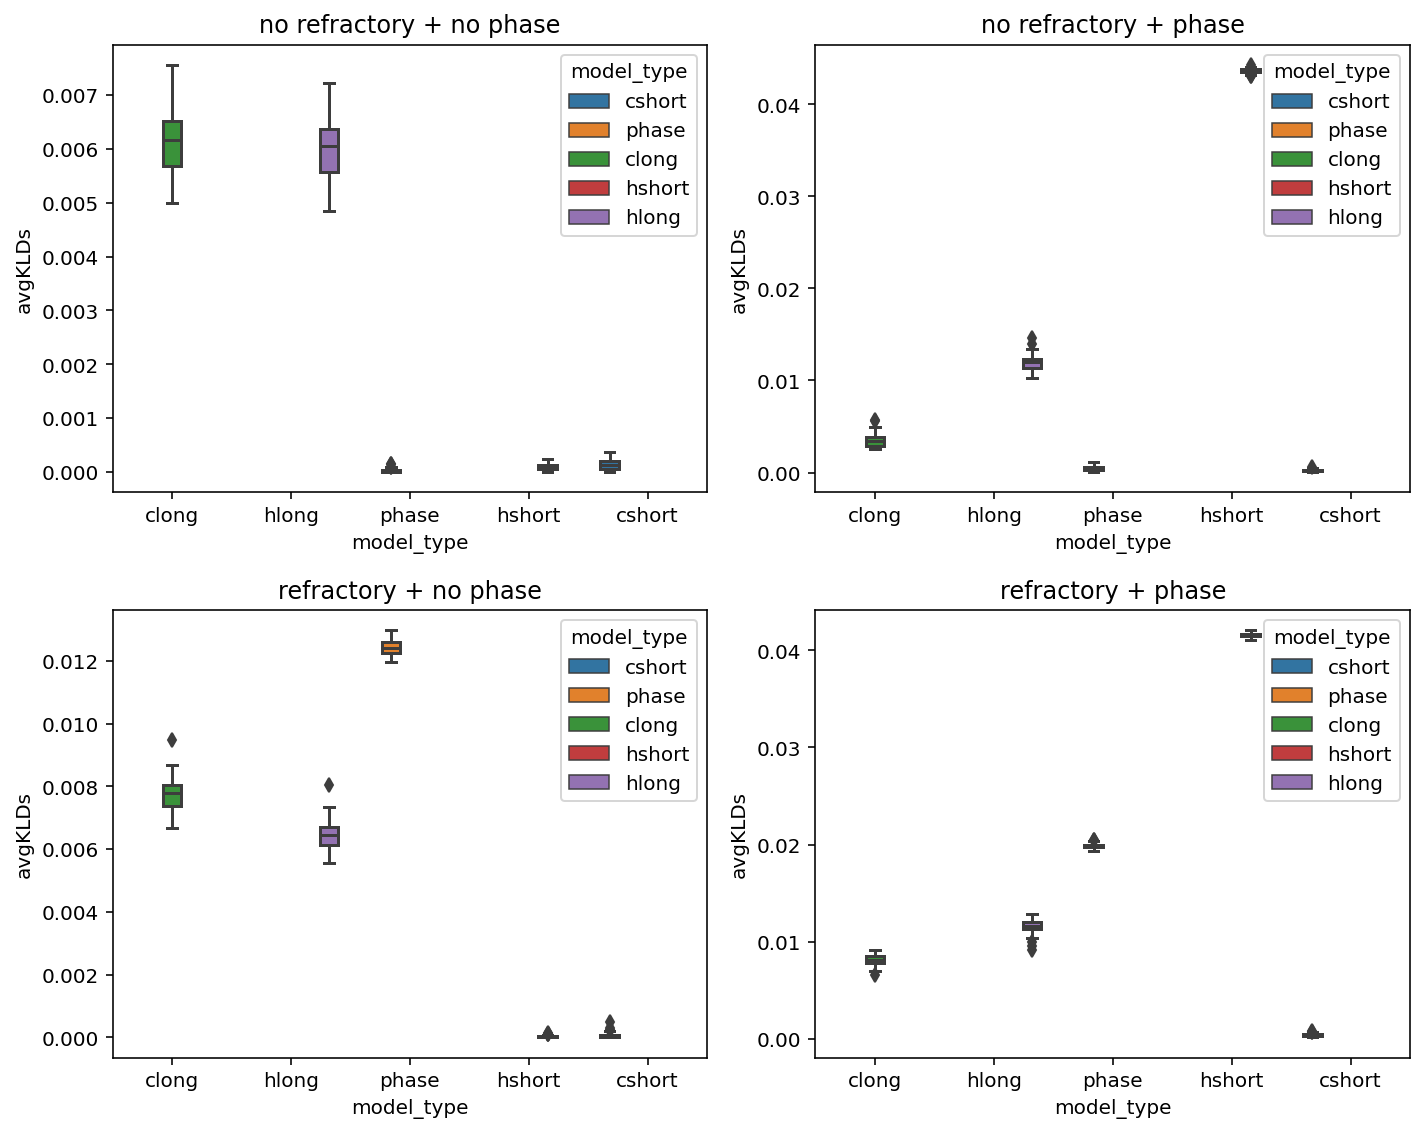

In [17]:
fig, ax = plt.subplots(2,2,figsize=(10,8))

## No Refractory No Phase
sub = sub_models[sub_models['cell_type']=='noRefractorynoPhase']
sns.boxplot(data=sub,
            x='model_type',
            y='avgKLDs',
            hue='model_type',
            order=['clong','hlong','phase','hshort','cshort'],
            ax=ax[0][0]).set_title('no refractory + no phase')
# ax[0][0].set_ylim(0,0.008)

## Refractory No Phase
sub=[]
sub = sub_models[sub_models['cell_type']=='RefractorynoPhase']
sns.boxplot(data=sub,
            x='model_type',
            y='avgKLDs',
            hue='model_type',
            order=['clong','hlong','phase','hshort','cshort'],
            ax=ax[1][0]).set_title('refractory + no phase')
# ax[1][0].set_ylim(0,0.008)

## no Refractory Phase
sub=[]
sub = sub_models[sub_models['cell_type']=='noRefractoryPhase']
sns.boxplot(data=sub,
            x='model_type',
            y='avgKLDs',
            hue='model_type',
            order=['clong','hlong','phase','hshort','cshort'],
            ax=ax[0][1]).set_title('no refractory + phase')
# ax[0][1].set_ylim(0,0.008)

## Refractory Phase
sub=[]
sub = sub_models[sub_models['cell_type']=='RefractoryPhase']
sns.boxplot(data=sub,
            x='model_type',
            y='avgKLDs',
            hue='model_type',
            order=['clong','hlong','phase','hshort','cshort'],
            ax=ax[1][1]).set_title('refractory + phase')
# ax[1][1].set_ylim(0,0.008)

fig.tight_layout()
fig.savefig('JNP_revision3_avgKLDs_simneurons60Hz_boxplots.pdf')


The "penalty" on the phase model increases drastically with increasing firing rate in cases where there is a refractory period. Compare this result to the simulated 6 Hz spike trains, which had very little phase model penalty because spiking was so rare.

In [22]:
cell_type = []
for i in range(df_sim_loglossdeltas.shape[0]):
    prev_type = df_sim_loglossdeltas['cell_type'].iloc[i]
    cell_type.append(prev_type)
    
df_sim_loglossdeltas['cell_type1'] = cell_type 

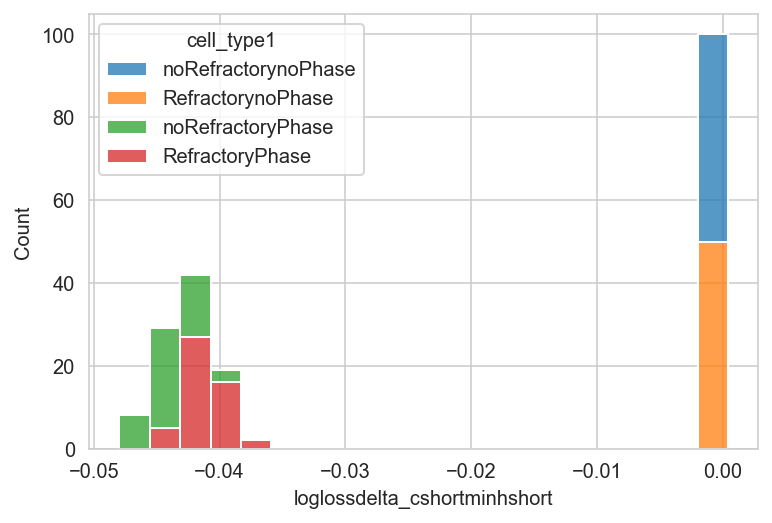

In [25]:
sns.set_style("whitegrid")

fig,ax = plt.subplots()

sns.histplot(data=df_sim_loglossdeltas,x='loglossdelta_cshortminhshort',hue='cell_type1',bins=20, multiple="stack",ax=ax)

fig.savefig('JNP_revision3_loglossdeltas_cshortvRawhshort_simneurons60Hz.pdf')



## Verify the actual spike rate of the simulated spike trains

In [33]:
frates = []
for folder in datafolders: 
    
    folderpath = folder + '/target_frate/' + '/60/'
    subpath = os.path.join(datapath_single,folderpath)
    files = os.listdir(subpath)
    files = [f for f in files if f.endswith('.csv')]
    files = [f for f in files if not f.startswith('.')]
    
    for file in files: 
        
        data = pd.read_csv(os.path.join(subpath,file))
        
        frate = (data['spikes'].sum()/data.shape[0])*1000
        frates.append(frate)

In [41]:
min(frates),max(frates),np.mean(frates),np.median(frates)

(41.80555555555556, 61.36111111111111, 53.03326388888889, 54.38194444444444)

(0.0, 70.0)

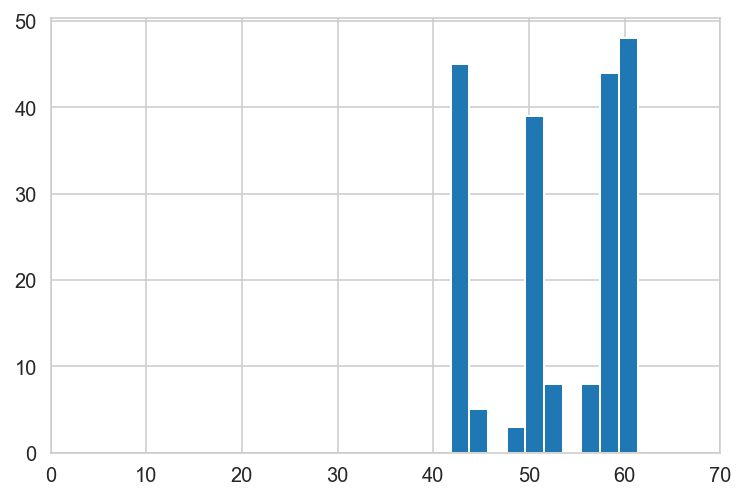

In [36]:
plt.hist(frates)
plt.xlim(0,70)